In [1]:
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.datasets import CelebA
import os
from accelerate import Accelerator
import segmentation_models_pytorch as smp

from dataclasses import dataclass


/home/jsooh/ssd/t5/envs/conda_envs/aging/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# data_dir = os.path.join(os.path.dirname(__file__), "..", "..", "data")
# path logic for notebook
data_dir = os.path.join(os.getcwd(), "..", "..", "data")

transform = T.Compose([
    T.CenterCrop(178),
    T.Resize(256),
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5]),
])

def make_unpaired_loader(root, split, batch_size=4, num_workers=1, limit=None, transform=transform):
    # download split
    full = CelebA(
        root=root,
        split=split,
        download=True,
        transform=transform,
    )
    
    # locate the "Young" attribute index
    young_attr_i = full.attr_names.index("Young")
    attrs = full.attr
    # split indices
    young_idx = (attrs[:, young_attr_i] == 1).nonzero(as_tuple=True)[0]
    old_idx = (attrs[:, young_attr_i] == 0).nonzero(as_tuple=True)[0]
    
    # limit each domain samples
    if limit is not None:
        gen = torch.Generator()
        perm_y = torch.randperm(len(young_idx), generator=gen)[:limit]
        perm_o = torch.randperm(len(old_idx), generator=gen)[:limit]
        young_idx = young_idx[perm_y]
        old_idx = old_idx[perm_o]
        
    # build subsets
    young_ds = Subset(full, young_idx)
    old_ds = Subset(full, old_idx)
    
    # unpaird wrapper
    @dataclass
    class Unpaired(Dataset):
        a: Dataset
        b: Dataset
        
        def __len__(self) -> int:
            return max(len(self.a), len(self.b))

        def __getitem__(self, idx: int):
            x, _ = self.a[idx % len(self.a)]
            y, _ = self.b[idx % len(self.b)]
            return x, y
    
    paired = Unpaired(young_ds, old_ds)
    print(f"- Finished spliting: {split} ({limit} examples)")
    return DataLoader(
        paired, batch_size=batch_size, shuffle=(split=="train"),
        num_workers=num_workers, pin_memory=True, drop_last=(split=="train")
    )

# loaders
print("Initializing dataset...")
train_loader = make_unpaired_loader(str(data_dir), "train", limit=20)
val_loader = make_unpaired_loader(str(data_dir), "valid", limit=4)
test_loader = make_unpaired_loader(str(data_dir), "test", limit=4)
print("Done.")

Initializing dataset...
- Finished spliting: train (20 examples)
- Finished spliting: valid (4 examples)
- Finished spliting: test (4 examples)
Done.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


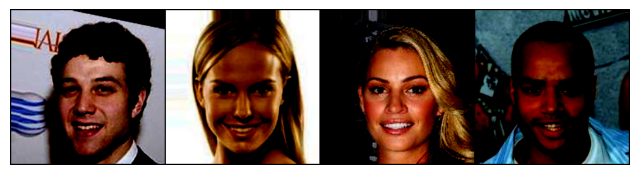

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


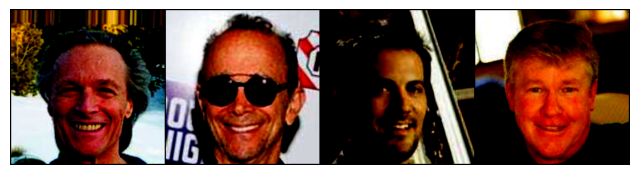

In [4]:
import torchvision

x,y = next(iter(train_loader))

grid_x = torchvision.utils.make_grid(x, nrow=4, padding=2)
grid_y = torchvision.utils.make_grid(y, nrow=4, padding=2)

# plot x
plt.figure(figsize=(8, 8))
plt.imshow(grid_x.permute(1, 2, 0))
plt.axis('off')
plt.show()

# plot y
plt.figure(figsize=(8, 8))
plt.imshow(grid_y.permute(1, 2, 0))
plt.axis('off')
plt.show()

## Models

In [5]:
# initilize the generators
G = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", # preload low-level filters
    in_channels=3, # RGB input
    classes=3, # RGB output
)

F = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet", # preload low-level filters
    in_channels=3, # RGB input
    classes=3, # RGB output
)

In [6]:
# Freeze encoder of model so that model can learn "aging" during the first epoch
def freeze_encoders():
    for param in G.encoder.parameters():
        param.requires_grad = False
    for param in F.encoder.parameters():
        param.requires_grad = False

# Unfreeze encoders later
def unfreeze_encoders():
    for param in G.encoder.parameters():
        param.requires_grad = True
    for param in F.encoder.parameters():
        param.requires_grad = True

freeze_encoders()

# sanity check
print("Trainable param in G:")
total_params = 0
total_trainable_params = 0
for name, param in G.named_parameters():
    total_params += 1
    if param.requires_grad:
        print(" ", name)
        total_trainable_params += 1

percent = total_trainable_params / total_params * 100
print(f"{total_trainable_params}/{total_params} | {percent:.1f} % of Total")

Trainable param in G:
  decoder.blocks.0.conv1.0.weight
  decoder.blocks.0.conv1.1.weight
  decoder.blocks.0.conv1.1.bias
  decoder.blocks.0.conv2.0.weight
  decoder.blocks.0.conv2.1.weight
  decoder.blocks.0.conv2.1.bias
  decoder.blocks.1.conv1.0.weight
  decoder.blocks.1.conv1.1.weight
  decoder.blocks.1.conv1.1.bias
  decoder.blocks.1.conv2.0.weight
  decoder.blocks.1.conv2.1.weight
  decoder.blocks.1.conv2.1.bias
  decoder.blocks.2.conv1.0.weight
  decoder.blocks.2.conv1.1.weight
  decoder.blocks.2.conv1.1.bias
  decoder.blocks.2.conv2.0.weight
  decoder.blocks.2.conv2.1.weight
  decoder.blocks.2.conv2.1.bias
  decoder.blocks.3.conv1.0.weight
  decoder.blocks.3.conv1.1.weight
  decoder.blocks.3.conv1.1.bias
  decoder.blocks.3.conv2.0.weight
  decoder.blocks.3.conv2.1.weight
  decoder.blocks.3.conv2.1.bias
  decoder.blocks.4.conv1.0.weight
  decoder.blocks.4.conv1.1.weight
  decoder.blocks.4.conv1.1.bias
  decoder.blocks.4.conv2.0.weight
  decoder.blocks.4.conv2.1.weight
  decoder.

In [7]:
# PatchGAN 70x70
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3, ndf=64):
        super().__init__()
        layers = [
            nn.Conv2d(
                in_channels=in_channels, 
                out_channels=ndf, 
                kernel_size=4, 
                stride=2, 
                padding=1),
            nn.LeakyReLU(0.2)
        ]
        nf = ndf
        for i in range(3):
            stride = 2 if i < 2 else 1
            layers += [
                nn.Conv2d(nf, nf*2, 4, stride, 1),
                nn.InstanceNorm2d(nf*2),
                nn.LeakyReLU(0.2)
            ]
            nf *= 2
        layers += [nn.Conv2d(nf, 1, 4, 1, 1)]
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
model = PatchDiscriminator()
x = torch.randn(1, 3, 256, 256)
out = model(x)
print(out.shape)

torch.Size([1, 1, 30, 30])


In [9]:
# initlize the discriminator
DX = PatchDiscriminator()
DY = PatchDiscriminator()

DX

PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [10]:
# initilize the optimizers
LR = 2e-4
opt_G = optim.Adam(filter(lambda p: p.requires_grad, G.parameters()), lr=LR, betas=(0.5,0.999))
opt_F = optim.Adam(filter(lambda p: p.requires_grad, F.parameters()), lr=LR, betas=(0.5,0.999))
opt_DX = optim.Adam(DX.parameters(), lr=LR, betas=(0.5,0.999))
opt_DY = optim.Adam(DY.parameters(), lr=LR, betas=(0.5,0.999))

# prepare (uses hf accelerate to move models o right device and wraps in optimzers too)
accelerator = Accelerator(mixed_precision="fp16")

G, F, DX, DY, opt_G, opt_F, opt_DX, opt_DY, train_loader, val_loader = accelerator.prepare(
    G, F, DX, DY, 
    opt_G, opt_F, opt_DX, opt_DY, 
    train_loader, val_loader
    # learning rate schedulers
) # everything lives on the GPU with automatic CPU fallback, distributed data parallel, mixed precision

## Train Logic

In [11]:
# loss functions and scalers
bce = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()
lambda_cyc = 10.0
lambda_id = 5.0

In [12]:
def perform_train_step(
    G, F, # generator models
    DX, DY, # discriminator models
    real_data,
    bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY, # discriminator optimizers
    accelerator,
):
    x, y = real_data
    # Generate fakes and reconstrucitons
    fake_x = F(y)
    fake_y = G(x)
    rec_x = F(fake_y)
    rec_y = G(fake_x)
    
    # ------ Update Discriminators ------
    # DX: real young vs fake young
    opt_DX.zero_grad(set_to_none=True) 
    real_logits = DX(x)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DX(fake_x.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DX loss + backprop + step
    loss_DX = 0.5 * (real_loss + fake_loss)
    accelerator.backward(loss_DX)
    opt_DX.step()
    # DY: real old vs fake old
    opt_DY.zero_grad(set_to_none=True) 
    real_logits = DY(y)
    real_targets = torch.ones_like(real_logits)
    real_loss = bce(real_logits, real_targets)
    
    fake_logits = DY(fake_y.detach())
    fake_targets = torch.zeros_like(fake_logits)
    fake_loss = bce(fake_logits, fake_targets)

    # DY loss + backprop + step
    loss_DY = 0.5 * (real_loss + fake_loss) # average loss to prevent discriminator learning "too quickly" compread to generators.
    accelerator.backward(loss_DY)
    opt_DY.step()
    
    # ------ Update Generators ------
    opt_G.zero_grad(set_to_none=True)
    opt_F.zero_grad(set_to_none=True)
    # Loss 1: adversarial terms
    fake_test_logits = DX(fake_x) # fake x logits
    loss_f_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    
    fake_test_logits = DY(fake_y) # fake y logits
    loss_g_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
    # Loss 2: cycle terms
    loss_cyc = lambda_cyc * (l1(rec_x, x) + l1(rec_y, y))
    # Loss 3: identity terms
    loss_id = lambda_id * (l1(G(y), y) + l1(F(x), x))
    # Total loss
    loss_gen_total = loss_g_adv + loss_f_adv + loss_cyc + loss_id

    # Backprop + step
    accelerator.backward(loss_gen_total)
    opt_G.step()
    opt_F.step()
    
    return {
        "loss_DX": loss_DX.item(),
        "loss_DY": loss_DY.item(),
        "loss_f_adv": loss_f_adv.item(),
        "loss_g_adv": loss_g_adv.item(),
        "loss_cyc": loss_cyc.item(),
        "loss_id": loss_id.item(),
        "loss_gen_total": loss_gen_total.item() 
    }

In [13]:
def perform_val_epoch(
    G, F, # generator models
    DX, DY, # discriminator models
    val_loader,
    bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
):
    # change to eval mode
    G.eval()
    F.eval()
    DX.eval()
    DY.eval()
    
    metrics = {
        "loss_DX": 0.0,
        "loss_DY": 0.0,
        "loss_f_adv": 0.0,
        "loss_g_adv": 0.0,
        "loss_cyc": 0.0,
        "loss_id": 0.0,
        "loss_gen_total": 0.0,
    }
    n_batches = 0
    
    with torch.no_grad():        
        for x, y in val_loader:        
            # Forward: Generate fakes and reconstrucitons
            fake_x = F(y)
            fake_y = G(x)
            rec_x = F(fake_y)
            rec_y = G(fake_x)
            
            # ------ Evaluate Discriminators ------
            # DX: real young vs fake young
            real_logits = DX(x)
            real_targets = torch.ones_like(real_logits)
            real_loss = bce(real_logits, real_targets)
            
            fake_logits = DX(fake_x)
            fake_targets = torch.zeros_like(fake_logits)
            fake_loss = bce(fake_logits, fake_targets)
            # DX loss
            loss_DX = 0.5 * (real_loss + fake_loss)
            
            # DY: real old vs fake old
            real_logits = DY(y)
            real_targets = torch.ones_like(real_logits)
            real_loss = bce(real_logits, real_targets)
            
            fake_logits = DY(fake_y)
            fake_targets = torch.zeros_like(fake_logits)
            fake_loss = bce(fake_logits, fake_targets)

            # DY loss
            loss_DY = 0.5 * (real_loss + fake_loss) # average loss to prevent discriminator learning "too quickly" compread to generators.
            
            # ------ Evaluate Generators ------
            # Loss 1: adversarial terms
            fake_test_logits = DX(fake_x) # fake x logits
            loss_f_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
            
            fake_test_logits = DY(fake_y) # fake y logits
            loss_g_adv = bce(fake_test_logits, torch.ones_like(fake_test_logits))
            # Loss 2: cycle terms
            loss_cyc = lambda_cyc * (l1(rec_x, x) + l1(rec_y, y))
            # Loss 3: identity terms
            loss_id = lambda_id * (l1(G(y), y) + l1(F(x), x))
            # Total loss
            loss_gen_total = loss_g_adv + loss_f_adv + loss_cyc + loss_id
            
            # ------ Accumulate ------
            metrics["loss_DX"] += loss_DX.item()
            metrics["loss_DY"] += loss_DY.item()
            metrics["loss_f_adv"] += loss_f_adv.item()
            metrics["loss_g_adv"] += loss_g_adv.item()
            metrics["loss_cyc"] += loss_cyc.item()
            metrics["loss_id"] += loss_id.item()
            metrics["loss_gen_total"] += loss_gen_total.item()
            
            n_batches += 1
    
    # per-batch average
    for k in metrics:
        metrics[k] /= n_batches

    return metrics

In [14]:
PRINT_STATS_AFTER_BATCH = 1

def perform_epoch(
    train_loader, val_loader,
    G, F,
    DX, DY,
    bce, l1, lambda_cyc, lambda_id,
    opt_G, opt_F, # generator optimizers
    opt_DX, opt_DY, # discriminator optimizers
    epoch,
    accelerator,
):
    """ Perform a single epoch."""
    print("Training...")
    # Training
    G.train()
    F.train()
    DX.train()
    DY.train()
    for batch_no, real_data in enumerate(train_loader):      
        train_metrics = perform_train_step(
            G, F, # generator models
            DX, DY, # discriminator models
            real_data,
            bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
            opt_G, opt_F, # generator optimizers
            opt_DX, opt_DY, # discriminator optimizers
            accelerator
        )
        # Print statistics and generate iamge after every n-th batch
        if batch_no % PRINT_STATS_AFTER_BATCH == 0:
            print(f"loss_DX: {train_metrics['loss_DX']:.4f} | loss_DY: {train_metrics['loss_DY']:.4f} | loss_gen_total: {train_metrics['loss_gen_total']:.4f} | loss_g_adv: {train_metrics['loss_g_adv']:.4f} | loss_f_adv: {train_metrics['loss_f_adv']:.4f} | loss_cyc: {train_metrics['loss_cyc']:.4f} | loss_id: {train_metrics['loss_id']:.4f}")
            # generate_image(G, epoch, batch_no)
    # Evaluation
    print("Evlauating...")
    val_metrics = perform_val_epoch(
        G, F, # generator models
        DX, DY, # discriminator models
        val_loader,
        bce, l1, lambda_cyc, lambda_id, # loss functions and loss params
    )
    print(f"loss_DX: {val_metrics['loss_DX']:.4f} | loss_DY: {val_metrics['loss_DY']:.4f} | loss_gen_total: {val_metrics['loss_gen_total']:.4f} | loss_g_adv: {val_metrics['loss_g_adv']:.4f} | loss_f_adv: {val_metrics['loss_f_adv']:.4f} | loss_cyc: {val_metrics['loss_cyc']:.4f} | loss_id: {val_metrics['loss_id']:.4f}")
    # # Save models on epoch completion
    # save_models(G, F, DX, DY, lambda_cyc, lambda_id, epoch)
    # Clear memory after every epoch
    torch.cuda.empty_cache()

In [15]:
NUM_EPOCHS = 2

def main():
    """ Train the CycleGan """
    # Speed ups
    torch.autograd.set_detect_anomaly(False)
    torch.autograd.profiler.profile(False)
    torch.autograd.profiler.emit_nvtx(False)
    torch.backends.cudnn.benchmark = True
    
    # Make directory for unique run
    # make_directory_for_run()
    # Set fixed random number seed if wanted
    # set_seed()
    # Get prepared dataset
    # dataloader = prepare_dataset()
    # Initialize models
    # = initalize_models()
    # Initialize loss and optimizers
    # = initialize_loss()
    # = initialize_optimizers()
    # Train the model
    for epoch in range(NUM_EPOCHS):
        print(f"\nStarting epoch {epoch}...")
        perform_epoch(
            train_loader, val_loader,
            G, F,
            DX, DY,
            bce, l1, lambda_cyc, lambda_id,
            opt_G, opt_F, # generator optimizers
            opt_DX, opt_DY, # discriminator optimizers
            epoch,
            accelerator,
        )
    # Finished
    print(f"Finished run")

In [16]:
if __name__ == "__main__":
    main()


Starting epoch 0...
Training...


loss_DX: 0.7133 | loss_DY: 0.7234 | loss_gen_total: 27.8951 | loss_g_adv: 0.9051 | loss_f_adv: 0.9634 | loss_cyc: 17.2710 | loss_id: 8.7556
loss_DX: 0.9314 | loss_DY: 0.9391 | loss_gen_total: 28.4228 | loss_g_adv: 0.9195 | loss_f_adv: 0.9022 | loss_cyc: 17.7279 | loss_id: 8.8731
loss_DX: 0.7563 | loss_DY: 0.7263 | loss_gen_total: 28.2368 | loss_g_adv: 0.8287 | loss_f_adv: 0.7643 | loss_cyc: 17.7028 | loss_id: 8.9410
loss_DX: 0.7016 | loss_DY: 0.6951 | loss_gen_total: 26.4821 | loss_g_adv: 0.7410 | loss_f_adv: 0.6816 | loss_cyc: 16.6818 | loss_id: 8.3777
loss_DX: 0.6763 | loss_DY: 0.7125 | loss_gen_total: 28.9779 | loss_g_adv: 0.7215 | loss_f_adv: 0.7082 | loss_cyc: 18.3960 | loss_id: 9.1523
Evlauating...
loss_DX: 0.6707 | loss_DY: 0.6629 | loss_gen_total: 24.0076 | loss_g_adv: 0.7180 | loss_f_adv: 0.7054 | loss_cyc: 15.1551 | loss_id: 7.4291

Starting epoch 1...
Training...
loss_DX: 0.6558 | loss_DY: 0.6815 | loss_gen_total: 27.2858 | loss_g_adv: 0.7312 | loss_f_adv: 0.7744 | loss_cyc:

In [ ]:
# add test_loader to accelerate before testing on it